# Microfossils, Remote Sensing, and GIS for Proxy-dating Coastal Archaeological Sites and Landscapes: A case from Minas Basin, Bay of Fundy, Canada

This Jupyter Notebook is intended to replicate the production of geochronological *terminus ante quem* boundaries for the Kingsport marsh as described in the associated article. 

Loading this *AppendixB* Jupyter Notebook as a Binder increases reproducability of the workflow employed to create the geochronological boundaries.

The notebook can be broken down as follows:

1. Import Packages


2. Visualize Study Area


3. CSV Data Import


4. Marine Resevoir Correction & Radiocarbon Calibration


5. Elevation Correction of Sea Level Proxy Samples


6. Calculating Sea Level Rise (Higher High Water)


7. Calculating Equvalent Past HHW at Oak Point


8. Proxy Dating Rooted Stumps in a Drowned Forest

## 1. Import Packages

The first step is to import the required Python packages to replicate the method presented in the associated article. 

Running the following codeblock imports the required packages. 

In [1]:
import numpy as np
import pandas as pd
import iosacal
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
import random
import requests

from ipyleaflet import *
%matplotlib inline

from pprint import pprint
from numpy import ones,vstack
from numpy.linalg import lstsq
from iosacal import R, iplot
from iosacal.text import single_text
from ipywidgets import HTML
from pandas import *
from matplotlib import pyplot, figure
from IPython.display import clear_output

## 2. Visualize Study Area

An interactive map frame powered by iPyLeaflet is prepared by running the proceeding code block. The map frame is centered on the Oak Point study area at Kingsport marsh.

We define the map frame as *mapFrame* on line 1 followed by adding data and functionality: 

- ESRI satellite imagery basemap
- custom map tile layer from the lidar basemaps shown in the article
- measurement functionality
- full screen functionality
- scale bar
- layer toggle functionality

In [2]:
#initialize map as "mapFrame"
mapFrame = Map(basemap=basemaps.Esri.WorldImagery, center=(45.1562107, -64.3699627), zoom=15, max_zoom=18)

#load and add local tile layer
basemap = LocalTileLayer(name="Shaded Relief",tms = True, attribution="Contains information licensed under the Open Government Licence – Nova Scotia. Created by: Wesley Weatherbee.", path="minasBase/{z}/{x}/{y}.png")
mapFrame.add_layer(basemap)

#load and add measurement function, fullscreen and layer toggle, and a visual scale
measure = MeasureControl(position='topleft',active_color = 'orange',primary_length_unit = 'meters')
mapFrame.add_control(measure)
measure.completed_color = 'red'
mapFrame.add_control(FullScreenControl(position='topright'))
mapFrame.add_control(LayersControl(position='topleft'))
mapFrame.add_control(ScaleControl(position='topright', metric=True))

Now we show the map frame by calling the variable referencing that data by running the following:

In [3]:
#show "mapFrame" map
mapFrame

Map(center=[45.1562107, -64.3699627], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

##### Creation of the map data

The open map above displays datasets that will help explore the output boundaries after running this notebook. The extent of the shaded relief mirrors that of Figure 1 in the associated article presenting a high resolution maximum zoom level of 18 throughout.

The shaded relief layer was created from Lidar derived digital elevation models at 1m resolution from the [Province of Nova Scotia](url: "https://nsgi.novascotia.ca/datalocator/elevation/"). The layer is a series of compressed .png tiles within an organized folder directory using naming conventions relating to geolocation. This directory is located at */minasBase* off of the Binder root folder. 

The */minasBase* directory was automatically created from a Map Tile Package (.tpk) file exported from ArcGIS Pro. With the help of python modules `tpkutils` and `mbutil`, the .tpk was converted to a .mbtiles, MapBox tile package file then extracted to the */minasBase* directory. 

Optimization of the map tiles is responsible for the high zooom level display presented in this Binder. An original file count for the */minasBase* map tiles directory exceeded 5 million, which was not appreciated by GitHub or Binder. However, with the help of native python modules, the file count was reduced to approximately 37000 by removing any .png images in the directory that were a size of 190 bytes or smaller—files of this size contained no image data, only a transparency layer. 

## 3. CSV Data Import

Following the data preparation steps outlined in the methods section of the associated article, we have placed a CSV titled **Appendix A**  within the */data* folder. The following codeblock will display the *AppendixA.csv* file as a table.
<br><br>
The first line calls the CSV from the location within the project folder and loads it into a 'pandas' dataframe called *AppendixA*. Our second line defines formatting, cell alignment, and styles to be applied when we call the variable *Table*. *Table* is called in the third line and our formatted CSV is shown below.

In [4]:
#read CSV file to pandas dataframe
AppendixA = pd.read_csv("./data/AppendixA.csv")

#create table style
Table = AppendixA.style.format({"error": lambda x: "±{:.1f}".format(abs(x))}, na_rep="-").format({"date": lambda x: "{:.1f} C14BP".format(float(x))}).format({"core_depth": lambda x: "{:.2f}m".format(abs(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_corrected": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_error": lambda x: "±{:.2f}m".format(float(x))}, na_rep="-").set_properties(subset=["error", "core_depth", "modern_HHW", "HHW_corrected", "HHW_error"], **{'text-align': 'center'}).set_properties(subset=["date"], **{'text-align': 'right'})

#show sylized table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4430.0 C14BP,±215.0,9.50m,6.805m,-,±0.20m
1,Gx-6811,2905.0 C14BP,±220.0,6.50m,6.796m,-,±0.55m
2,Gx-6812,2355.0 C14BP,±180.0,4.50m,6.795m,-,±0.20m


CSV data in the data frame can be quickly plotted by calling the attributes we wish to plot. The codeblock below plots the relationship of core depth to date of sample recovered from that depth in radiocarbon years.

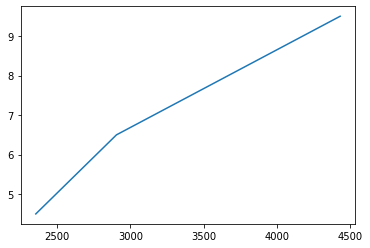

In [5]:
#load date and sample depth values from CSV as lists
date = AppendixA['date']
depth = AppendixA['core_depth']

#plot the list values as an x, y relationship
plt.plot(date, depth);

## 4. Marine Resevoir Correction & Radiocarbon Calibration

Now that we have our CSV holding the necessary data to begin, we need to correct for marine resevoir effect, then calibrate our radiocarbon dates. Mentioned in the associated article, the ΔR of -64 ±90 (obtained from [CALIB](url=http://calib.org/marine/)) is subtracted from each radiocarbon date before calibration occurs. The codeblock below will perform this calculation. As per usual, when addition or subtraction between two values with reported errors, the errors are summed.

In [6]:
#apply marine resevoir correction to date and error values in table
AppendixA["date"] = AppendixA["date"] - (-64)
AppendixA["error"] = AppendixA["error"] + (90)

#show stylized table
Table

,ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
0,Gx-6810,4494.0 C14BP,±305.0,9.50m,6.805m,-,±0.20m
1,Gx-6811,2969.0 C14BP,±310.0,6.50m,6.796m,-,±0.55m
2,Gx-6812,2419.0 C14BP,±270.0,4.50m,6.795m,-,±0.20m


#### Calibrating Sample Data

The python package IOSACal is used in the following to calibrate the radiocarbon dates obtained from samples at Kingsport. 

The values in the associated article use the MARINE20 calibration curve released in 2020. The most recent IOSACal version (v0.4.1) does not come with the MARINE20 or INTCAL20 .14c calibration curve files, but were manually added to a local distribution for publication purposes. In the following, the exact same process is run on the same samples using the MARINE13 calibration curve file. Slightly different results ensue, but the code will be updated to reference the new calibration curve once IOSACal v0.5.0 is released.

Records from the CSV file are used as input for a loop calibrating the input dates in the following radiocarbon calibration. The output is a short report and a probability distribution plot for each of the calibrations.

To prepare for this process we create variables to hold the inputs and outputs of the calibration in the following codeblock. first three lines of code define the variables `s`, `d`, and `e` as values from specified columns in our dataframe (`ID`, `date`, & `error`). The following two lines initialize empty lists, `cal68` and `cal95`, that will store the minimum and maximum date of each confidence interval for each sample.

In [7]:
#create variables for sample id, date, and date error
s = AppendixA.ID.values
d = AppendixA.date.values
e = AppendixA.error.values

#create a list to hold min and max values of probability distributions
cal68 = []
cal95 = []

A lot worthy of explaination happens in the codeblock.

Beginning with line 1, the following text described the process of our loop line by line.

Line 1 is the header of our `for` loop. The header defines the parameters of our loop, and describes the conditions to be met `for` the loop to stop. Our conditions state iterate the body of the loop below `for` a number of times equal to the `range` of `axis` `0`, or `rows`, in `AppendixA`. We have three samples, so the loop will iterate a total of three times with the provided data.<br>

Line 2 begins the body of the loop by defining a variable called `r` as equal to the values of date (`d`), error (`e`), and ID (`s`). The variables are designated as radiocarbon dates with the variable `R` (shorthand in IOSACal). The `i` in square brackets following `d`, `e`, and `s` is a reference to the value of `date`, `error`, and `ID` for the record with an index matching the current iteration of the loop. The `r` variable now holds a list containing the three values for each of the three samples. <br>

Line 3 passes the values of our list stored in `r` to the `calibrate` method in IOSACal. By prefixing `r` to `.calibrate` we are defining that the values in `r` will will be calibrated using the selected calibration curve. The calculated values are saved in the variable `cal_r`. <br>

Line 4 creates a report for the calibration, saved to the variable - `report`.<br>

On line 5, we search the output report text for digits, storing them in as a list in the variable called `findDigits`. Line 6 and 7 append the min and max values from our `findDigits` list for the 68% and 95% confidence intervals, based on their position in the list. These lines take advantage of the consistent structure IOSACal uses for reporting to allow us to directly use the outputs in further analysis.<br>

Lines 8 and 9 then `print` the report stored in our `report` variable below our code, and creates and saves a visualization of the calibration to the directory - `/SupplementaryData/output` as a JPG image named by `ID`.

**REMINDER:** *the most recent release of IOSACal (v.0.4.1) does not include the MARINE20 calibration curve. This notebook currently uses MARINE13 for radiocarbon calibration, while dates reported within the article use MARINE20. This results in slight variances between MARINE20 dates in the article and MARINE13 dates produced below. Upon release, IOSACal v0.5.0 will be automatically installed with the Binder image running this notebook, and code will promptly be updated to make use of the most recent dataset.*


# Gx-6810

Calibration of Gx-6810: 4494 ± 305 BP

## Calibrated age

Marine data from Reimer et al (2013);

### 68.2% probability

* 5064 CalBP - 4244 CalBP (68.2%)

### 95.4% probability

* 5449 CalBP - 3876 CalBP (95.4%)

----

IOSACal v0.4.1



# Gx-6811

Calibration of Gx-6811: 2969 ± 310 BP

## Calibrated age

Marine data from Reimer et al (2013);

### 68.2% probability

* 3102 CalBP - 2339 CalBP (68.2%)

### 95.4% probability

* 3474 CalBP - 1964 CalBP (95.4%)

----

IOSACal v0.4.1



# Gx-6812

Calibration of Gx-6812: 2419 ± 270 BP

## Calibrated age

Marine data from Reimer et al (2013);

### 68.2% probability

* 2367 CalBP - 1710 CalBP (68.1%)

### 95.4% probability

* 2722 CalBP - 1459 CalBP (95.3%)
* 1451 CalBP - 1449 CalBP (0.1%)

----

IOSACal v0.4.1




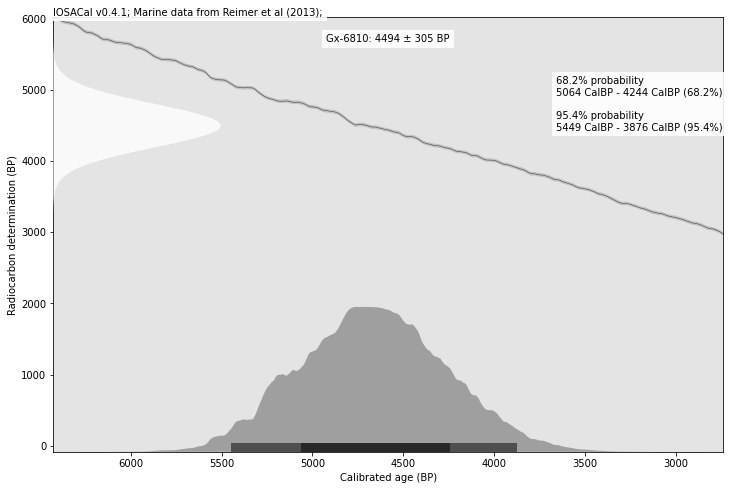

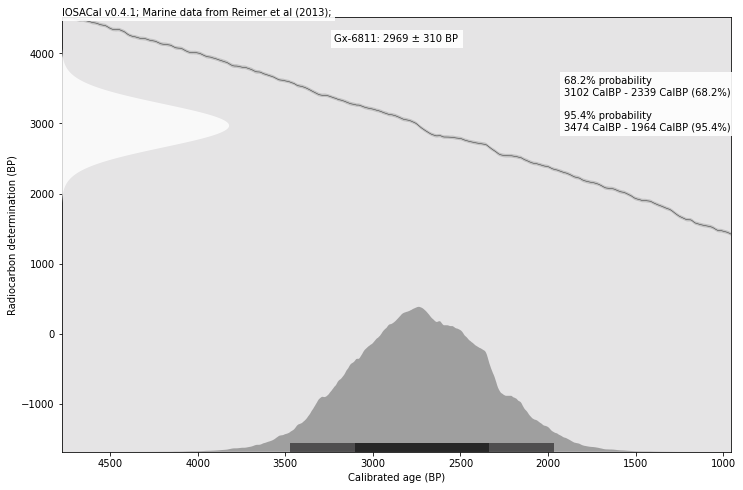

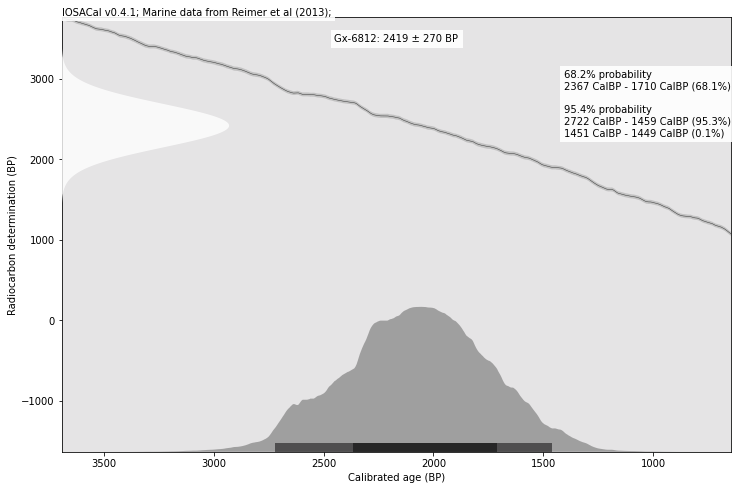

In [8]:
#define the output directory
dir= r"./output/"

#begin for loop iterating through all input records 
for i in range(AppendixA.shape[0]):
    
    #sort date, error, and sample id records and add input radiocarbon sample list
    r = R(d[i], e[i], s[i])
    
    #calibrate dates with the calibration curve shown in quotes
    cal_r = r.calibrate('marine13')
    
    #create text based output report for radiocarbon calibration
    report = (single_text(cal_r))
    
    #add all integer only words of one of more digits in the report to a list
    findDigits = [int(s) for s in re.findall(r'\b\d+\b', report)]
    
    #append the resulting list values to new lists
    #68% confidence interval values are location 7 and 8
    #95% confidence interval values are location 13 and 14
    cal68.append(findDigits[7:9])
    cal95.append(findDigits[13:15])
    
    #print report for current sample as output
    print(report)
    
    #show probability distribution plot as inline plot below output
    iplot(cal_r, output = dir + s[i] + ".jpg")

After performing radiocarbon calibration, the output lists are cast to a `numpy array` for storage as float values. These values are put into a `for` loop that iterates for `i` number of times. The number of iterations is set using the `range()` function with an input parameter of a list of values. For flexibility on the number of records that can be input to this code this value is equal the the number of records in our input table by calling the shape of any column with `AppendixA.shape[0]` (here we chose the first column `0`).

Within the `for` loop, simple calculations run over 1σ (68%) and 2σ (95%) confidence intervals to retrieve maximum, minimum, mean and associated uncertainty of each sample in calibrated years before present (CalBP) . These values are appended to the variables `cal95Date`,  `cal95Mean`,  `cal95Err`, `d`, and `e` for use later in the workflow.

In [9]:
#create array objects to hold values not created above
cal68Date = np.array(cal68)
cal95Date = np.array(cal95)
cal95Mean = np.array(d)
cal95Err = np.array(e)

#begin for loop iterating through all input records 
for i in range(AppendixA.shape[0]):
    
    #calculate mean and uncertainty for 68% confidence intervals
    d[i] = (cal68Date[i,0]+cal68Date[i,1])/2
    e[i] = (cal68Date[i,0]-cal68Date[i,1])/2
    
    #calculate mean and uncertainty for 95% confidence intervals
    cal95Mean[i] = (cal95Date[i,0]+cal95Date[i,1])/2
    cal95Err[i] = (cal95Date[i,0]-cal95Date[i,1])/2

The resulting values are used to modify the formatted *Table* dataframe shown after running the following:

In [10]:
#restyle the Table dataframe to output CalBP
Table = AppendixA.style.hide_index().format({"error": lambda x: "±{:.1f}".format(abs(x))}, na_rep="-").format({"date": lambda x: "{:.0f} CalBP".format(float(x))}).format({"core_depth": lambda x: "{:.2f}m".format(abs(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_corrected": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_error": lambda x: "±{:.2f}m".format(float(x))}, na_rep="-").set_properties(subset=["error", "core_depth", "modern_HHW", "HHW_corrected", "HHW_error"], **{'text-align': 'center'}).set_properties(subset=["date"], **{'text-align': 'left'})

#show table
Table

ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
Gx-6810,4654 CalBP,±410.0,9.50m,6.805m,-,±0.20m
Gx-6811,2720 CalBP,±381.0,6.50m,6.796m,-,±0.55m
Gx-6812,2038 CalBP,±328.0,4.50m,6.795m,-,±0.20m


Results of the radiocarbon calibration are viewed in more detail below. The following codeblock creates and displays a new dataframe formatted to show date range, mean, and uncertainty at both confidence intervals for all samples calibrated.

In [11]:
#define columns of radiocarbon calibration table
cols = ['2'+'\u03C3'+' Max Age', '2'+'\u03C3'+' Min Age']
cols2 = ['1'+'\u03C3'+' Max Age', '1'+'\u03C3'+' Min Age']
cols3 = ['2'+'\u03C3'+' Mean Age', '2'+'\u03C3'+' Uncertainty', '1'+'\u03C3'+' Mean Age', '1'+'\u03C3'+' Uncertainty'] 

#create an array holding mean date and uncertainty at each confidence interval
calMean = np.column_stack((cal95Mean,cal95Err,d,e))

#load cal95 list to a data frame and add column titles
calDates = pd.DataFrame(cal95)
calDates.columns = cols

#add remaining datasets and column titles
calDates.reindex(columns=calDates.columns.tolist() + cols2)
calDates[cols2] = cal68
calDates.reindex(columns=calDates.columns.tolist() + cols3)
calDates[cols3] = calMean.reshape(3,4)
calDates.insert(0, "Sample ID", AppendixA.iloc[0:3,0])

#stylize and show full results of radiocarbon calibration in a table
calDates.style.hide_index().set_properties([], **{'text-align': 'center'}).format({'2'+'\u03C3'+' Max Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'2'+'\u03C3'+' Min Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'1'+'\u03C3'+' Mean Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'2'+'\u03C3'+' Mean Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'1'+'\u03C3'+' Max Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'1'+'\u03C3'+' Min Age': lambda x: "{:.0f} CalBP".format(float(x))}).format({'2'+'\u03C3'+' Uncertainty': lambda x: "±{:.0f} ".format(float(x))}).format({'1'+'\u03C3'+' Uncertainty': lambda x: "±{:.0f} ".format(float(x))}).set_properties(subset=['2'+'\u03C3'+' Uncertainty','1'+'\u03C3'+' Uncertainty'], **{'text-align': 'left'})

Sample ID,2σ Max Age,2σ Min Age,1σ Max Age,1σ Min Age,2σ Mean Age,2σ Uncertainty,1σ Mean Age,1σ Uncertainty
Gx-6810,5449 CalBP,3876 CalBP,5064 CalBP,4244 CalBP,4662 CalBP,±786,4654 CalBP,±410
Gx-6811,3474 CalBP,1964 CalBP,3102 CalBP,2339 CalBP,2719 CalBP,±755,2720 CalBP,±381
Gx-6812,2722 CalBP,1459 CalBP,2367 CalBP,1710 CalBP,2090 CalBP,±631,2038 CalBP,±328


## 5. Elevation Correction of Sea Level Proxy Samples

### Calculating Sample Elevation

With radiocarbon calibration complete, production of the geochronological *terminus ante quem* boundaries can begin. Calculations shown below rely only on the 1σ (68%) confidence interval, while both intervals are used later to visualize the relative sea level over time.

First step is to calculate the elevation of the radiocarbon dated samples. These elevations will be used to derive past HHW in the CGVD2013 vertical datum.

The codeblock below subtracts *core_depth* from *modern_HHW* and places the result in the *HHW_corrected* column.

In [12]:
#calculate past high water elevation as current high water subtract depth of sample
AppendixA["HHW_corrected"] = AppendixA["modern_HHW"]-AppendixA["core_depth"]

#show formatted table
Table

ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
Gx-6810,4654 CalBP,±410.0,9.50m,6.805m,-2.695m,±0.20m
Gx-6811,2720 CalBP,±381.0,6.50m,6.796m,0.296m,±0.55m
Gx-6812,2038 CalBP,±328.0,4.50m,6.795m,2.295m,±0.20m


One sample, <i>Gx-6811</i>, was located within high marsh Zone 1b. The upper limit of Zone 1b will be 20cm below the limit of HHW mesasured from the top of Zone 1a.

The errors provided for <i>Gx-6811</i> cannot be reduced, but we can correct elevation to match the marine limit by adding the 20cm range in elevation for Zone 1a to the Zone 1b sample elevation.

The codeblock below performs this correction, then displays the updated values in our <i>AppendixA</i> dataframe.

In [13]:
#apply positive offset to account for the upper
#limit of zone 1b being 20cm below high-water
AppendixA.iloc[1:2,5] = AppendixA.iloc[1:2,5]+0.2

#show formatted table
Table

ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
Gx-6810,4654 CalBP,±410.0,9.50m,6.805m,-2.695m,±0.20m
Gx-6811,2720 CalBP,±381.0,6.50m,6.796m,0.496m,±0.55m
Gx-6812,2038 CalBP,±328.0,4.50m,6.795m,2.295m,±0.20m


## 6. Calculating Sea Level Rise (Higher High Water)

Our calculated HHW values for the Kingsport sample dates are shown above.

Next step is to determine the amount of RSL rise that has occurred since 1980 at the Kingsport sample locations. In order to do this, two coordinate pairs are required. Variables are defined below for our <i>x1</i>, <i>y1</i>, <i>x2</i>, and <i>y2</i> coordinates. Variable <i>x1</i> represents the radiocarbon equivalent date for the year 2020, where the value 0 is equal to the year 1950.

In [14]:
#define x1 as modern high water and remaining variables
#as values from the youngest calibrated sample
x1 = -70
x2 = AppendixA.loc[2].at["date"]
y1 = AppendixA.loc[2].at["modern_HHW"]
y2 = AppendixA.loc[2].at["HHW_corrected"]

We use our coordinate pairs from our table to derive the equation for the linear relationship between the most recent of the radiocarbon dated samples (*Gx-6812, HHW_corrected*) and modern HHW for that sample (*Gx-6812, modern_HHW*) following a  slightly modified codeblock ["from Stack Overflow"](https://stackoverflow.com/a/21566184). This equation will be used to solve for the HHW in the year 1980 by solving for x = -30 in the two following codeblocks. 

The first codeblock creates an object called *coords* from our *x1, y1*, and *x2, y2* coordinate pairs of date and elevation. We then use <b>zip()</b> to sort these pairs into *x_coords* and *y_coords* lists. The third line creates the coefficient matrix (*A*) for the least squares method, <b>lstsq()</b>, on line 4. The two derived values are the slope (<i>m</i>) and intercept (<i>c</i>) of our equation, printed below.

In [15]:
#define a list of coordinate pairs
coords = [(x1,y1),(x2,y2)]

#re-arrange the lists then add to an array
x_coords, y_coords = zip(*coords)
A = vstack([x_coords,ones(len(x_coords))]).T

#define variables m and b as the result of least-squares 
#regression using the input coordinate pairs
m, b = lstsq(A, y_coords, rcond=None)[0]

#print the equation
print("Equation is y = {:.5f}x + {:.5f}".format(m,b))

Equation is y = -0.00213x + 6.64557


Our output equation is: $$y = -0.00230x + 6.63404$$<br>

The following two codeblocks perform two calculations. First, a modeled HHW elevation value is calaculated for Kingsport in 1980 by solving for <i>y</i>, where: $$x = -30$$<br>  Next, RSL rise since 1980 at HHW is calculated from the difference in HHW compared to 2020.<br>

The following codeblock can also be expressed as: $$HHW_{1980} = 0.00230(-30) + 6.63404$$<br>

Our sea level rise calculation in the second codeblock is expressed as: $$RSLR_{[1980,2020]} = HHW_{2020} - (0.00230(-30) + 6.6340)$$<br>



In [16]:
SL = m * (-30) + b

print("Higher high water was", "{:.3f}m".format(SL),"CGVD2013 at Kingsport in 1980.")

Higher high water was 6.710m CGVD2013 at Kingsport in 1980.


In [17]:
SLR = y1 - SL
SLRcm = SLR*100

print("Sea level has risen", "{:.1f}cm".format(SLRcm),"since 1980 at Kingsport.")

Sea level has risen 8.5cm since 1980 at Kingsport.


As our <i>HHW_corrected</i> elevations for the Kingsport core samples are calculated as values for the year 2020, we need to correct the elevations to match depth below 1980 HHW. The calculation is performed in the codeblock below and expressed as: $$HHW\_corrected_{AppendixA} = HHW\_corrected_{AppendixA} - SLR$$

In [18]:
AppendixA["HHW_corrected"] = AppendixA["HHW_corrected"] - SLR
Table

ID,date,error,core_depth,modern_HHW,HHW_corrected,HHW_error
Gx-6810,4654 CalBP,±410.0,9.50m,6.805m,-2.780m,±0.20m
Gx-6811,2720 CalBP,±381.0,6.50m,6.796m,0.411m,±0.55m
Gx-6812,2038 CalBP,±328.0,4.50m,6.795m,2.210m,±0.20m


## 7. Calculating Equvalent Past HHW at Oak Point

An equivalent HHW elevation at Oak Point is obtained for each calibrated date by correcting for SLR and sample elevation.

An offset value for the geochronological boundary elevations at Oak Point is provided by the difference in RSL rise for the Kingsport sample because we can expect our high-marsh indicators to increase in elevation at the rate of RSL rise. 

The following codeblock calculates equivalent modern HHW elevations for Oak Point.

On line 1 the HHW value of <b>6.826</b> is used to calculate elevations for each sample subtracting <i>core_depth</i> and <i>SLR</i>. 

Line 2 displays the list of calculated values within <i>OakPointHHW</i>.

In [19]:
OakPointHHW = [6.826 - AppendixA.iloc[0:3,3] - SLR]
OakPointHHW

[0   -2.759389
 1    0.240611
 2    2.240611
 Name: core_depth, dtype: float64]

The following codeblock creates a new dataframe called <i>OakPoint</i> holding the calculated HHW elevations, calibrated dates, and errors at Oak Point.

Line 1 creates the dataframe from our <i>AppendixA</i> dataframe.

Line 2 replaces the <i>AppendixA</i> data originally in the <i>OakPoint</i> dataframe with values from the <i>OakPointHHW</i> list calculated above. 

Line 3 drops the unnecessary fields from the <i>AppendixA</i> dataframe.

Line 4 corrects the elevation for Zone 1b at Oak Point by adding the offset of 0.2m to the elevation of the second record.

Lines 5 and 6 stylize out table, and display the result.

In [20]:
OakPoint = pd.DataFrame(data=AppendixA)
OakPoint.iloc[0:3,5] = OakPointHHW[0]
OakPoint = OakPoint.drop(['ID','core_depth','modern_HHW'], axis=1)
OakPoint.iloc[1:2,2] = OakPoint.iloc[1:2,2] + 0.2
OakPointTable = OakPoint.style.hide_index().format({"error": lambda x: "±{:.1f}".format(abs(x))}, na_rep="-").format({"date": lambda x: "{:.1f} CalBP".format(float(x))}).format({"HHW_corrected": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_error": lambda x: "±{:.2f}m".format(float(x))}, na_rep="-").set_properties(subset=["error", "HHW_corrected", "HHW_error"], **{'text-align': 'center'}).set_properties(subset=["date"], **{'text-align': 'left'})
OakPointTable

date,error,HHW_corrected,HHW_error
4654.0 CalBP,±410.0,-2.759m,±0.20m
2720.0 CalBP,±381.0,0.441m,±0.55m
2038.0 CalBP,±328.0,2.241m,±0.20m


## 8. Proxy Dating Rooted Stumps in Drowned Forest

The *OakPoint* dataframe, shown above, holds HHW elevations at calibrated radiocarbon date intervals derived from samples located at Kingsport Marsh. 

In the following codeblock three json files are added to the map as new layers. The files contain polyline contours at the mean elevation of the *geochronological boundaries* produced using the MARINE20 calibration curve for sample *Gx-6810*. 

In [21]:
#load geojson file containing geochronological boundary data
with open(r"./data/HHW4460BP.geojson", 'r') as f:
    rsl1 = json.load(f)
with open(r"./data/HHW2550BP.geojson", 'r') as f:
    rsl2 = json.load(f)
with open(r"./data/HHW1890BP.geojson", 'r') as f:
    rsl3 = json.load(f)

#reference GeoJSON widgets as variables
hhw4460 = GeoJSON(data=rsl1, name="4460 BP High Water Limit", style={'opacity': 1, 'weight': 1, 'color': '#80bfff'})
hhw2550 = GeoJSON(data=rsl2, name="2550 BP High Water Limit", style={'opacity': 1, 'weight': 1, 'color': '#0099cc'})
hhw1890 = GeoJSON(data=rsl3, name="1890 BP High Water Limit", style={'opacity': 1, 'weight': 1, 'color': '#000000'})

#add data to map frame
mapFrame.add_layer(hhw4460)
mapFrame.add_layer(hhw2550)
mapFrame.add_layer(hhw1890)

Surveyed points have been gathered at Oak Point and throughout the mudflats of Minas Basin. Below we will load and visualize some survey data in the preexisting map frame.

In order to visualize submerged landscape features in relation to the modelled high water limits, surveyed points of many features were converted of a GeoJSON file. Below we open the GeoJSON file and view it as a table.

The table above allows scrolling to the side and displays attributes of the first json file.

Next the features can be plotted on our previous map frame. However, to differentiate the values a `Popup` method is used to visualize the `properties.Code` property of the points when a point is clicked. 

In [22]:
#load geojson file containing surveyed but undated rsl indicator points
with open(r"./data/rslPoints.geojson", 'r') as f:
    data = json.load(f)

#reference geojson feature ID as variable 'features'
features = data['features']
indElev = []
zErr = []

#create layer group referencing json records within the map frame
rslGroup = LayerGroup(name="RSL Indicators", layers=())

#loop over geojson features
for i in range(len(features)):
    location=(features[i]['geometry']['coordinates'][1],features[i]['geometry']['coordinates'][0])
    indicators = features[i]['properties']['Code']
    indElev.append(features[i]['properties']['OHeight'])
    zErr.append(features[i]['properties']['zError'])
    ind = str(indicators)
    html = """<p><b>Indicator type: </b>""" + f"{ind}" + """</p>"""
    rslPoint = CircleMarker( radius=4, color="#000000", location=location, weight=1, opacity=1, 
                             fill_opacity=0.8, fill_color="#80bfff", draggable=False)
    
    # Popup associated to a layer
    rslPoint.popup = HTML(html)
    rslGroup.add_layer(rslPoint)

#add group layer created from combined rslPoint layers
mapFrame.add_layer(rslGroup)

#call and display the map frame
mapFrame   

Map(center=[45.1562107, -64.3699627], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

The following were used to produce a plot of surveyed locations of stumps in the drowned forest in relation to sea level rise over-time. The cell below migrates calculated values from the *OakPoint* data frame in to a list. Current organization of the workflow required modern high water elevation and errors to be manually entered. Though this can be easily changed in the future.

In [23]:
#load x values to plot from the OakPoint data frame  
#then append the modern date relative to 1950
x = list(OakPoint['date'])
x.append(-70)

#load date uncertainty values to plot from the OakPoint 
#data frame  then append the modern date uncertainty
dateErr = list(OakPoint['error'])
dateErr.append(0)

#load y values to plot from the OakPoint data frame  
#then append the modern high water and uncertainty
y = list(OakPoint['HHW_corrected'])
y.append(6.826)
error = list(OakPoint['HHW_error'])
error.append(0.2)

Next, we create a plot using the same custom style used in the associated article. 

The cell below converts the lists above in to `numpy array` objects, obtains the values from the geojson indicator points we stored in variables previously, and plots the values using custom style parameters.

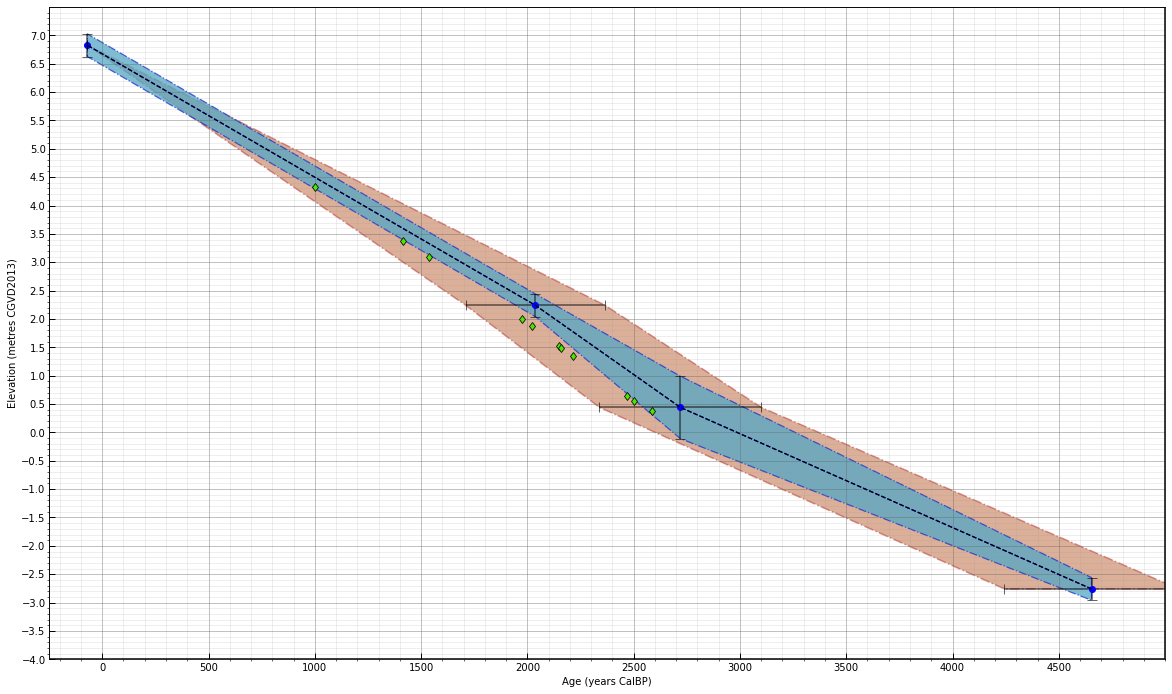

In [25]:
#use the seaborn style colorblind in the plot
plt.style.use('seaborn-colorblind')

#define method to round values to the nearest 5
def myround(x, base=5):
    return int(base * round(float(x)/base))

#define x, y, errors, indicator elevation, z-error, calculated date, and date error
x = np.array(x)
dateErr = np.array(dateErr)
y = np.array(y)
error = np.array(error)
indAge = np.array([1976.758241758242, 2022.1794871794873, 2146.7216117216117, 2158.443223443224, 2214.4871794871797, 2469.0659340659345, 2503.864468864469, 2585.688622754491, 1001.7565217391303, 1415.2347826086955, 1537.408695652174])

#plot points, errorbars, interpolated rsl indicator age, and errorbar bounds
plt.plot(x, y, 'bo', x, y, 'k', linewidth=1.25, linestyle='dashed')
plt.plot(indAge, indElev, 'd', color='#4CE600', markersize=6, markeredgewidth=0.75, markeredgecolor='k')
plt.fill_betweenx(y, x-dateErr, x+dateErr, alpha=0.4, edgecolor='#A80000', facecolor='#A83800',
    linewidth=1.5, linestyle='dashdot', antialiased=True)
plt.errorbar(x,y,error,dateErr, alpha=0.6, color='#1B2ACC', linewidth=0, elinewidth=1.5, ecolor='black', capsize=5)
plt.fill_between(x, y-error, y+error, alpha=0.75, edgecolor='#1B2ACC', facecolor='#51A8C7',
    linewidth=1.25, linestyle='dashdot', antialiased=True)

#stylize ticks, gridlines, bounds, and axis labels
plt.xticks(np.arange(0,5000, step=500))
plt.yticks(np.arange(-4,7.5, step=0.5))
plt.axhline(-4,color='black')
plt.axvline(-250,color='black')
plt.axhline(7.5,color='black')
plt.axvline(5000,color='black')
plt.tick_params(direction='in', length=6, width=1, colors='black',grid_color='gray', grid_alpha=0.5)
plt.xlabel('Age (years CalBP)')
plt.ylabel('Elevation (metres CGVD2013)')
plt.xlim(-250, 5000)
plt.ylim(-4, 7.5)

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='#666666')

# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', alpha=0.2)

#plot the figure and set the size
fig = plt.gcf()
fig.set_size_inches(20, 12)

The result of our above plot shows the relative sea-level curve for Oak Point. The calibrated dates were produced with the calibration curve used in the above process, and elevations were corrected using HHW points from a CHS grid surface for higher high water. Uncertainties associated with each point are shown with vertical and horizontal bars. 

A linear model is used to show interpolated uncertainty bounds over time. The red boundary relates to uncertainty of the radiocarbon calibration in the 68% confidence interval, while the blue boundary relates to the uncertainty associated with the *Foram.* assemblage derived relative sea level indicator points.